# UW Data Science - Methods of Data Analysis
## Dave Wine 8430191
## Assignment 2: Building Energy Efficiency Analysis - Continued



# Summary:

Assignment 2 Conclusion:

Additional observations for Assignment 2:
1. Even a small amount of glazing area appears to significantly increase the heating load.
2. The correlation with glazing area is consistent across all types of buildings and surface areas.
3. Orientation and Glazing Area Distribution don't seem to matter much.


(Assignment 1 Conclusions):
The graph below summarizes the important discoveries so far:
1. Tall buildings have lower surface area than short buildings.
2. Heating Loads of tall buildings and short buildings are clustered in two distinct areas - short buildings generally run less than 15, and tall buildings are between 15 and 40.
3. Glazing Area appears to have the next strongest effect on Heating Load.  Larger Glazing Area generally implies higher Heating Load.


Note:  This week for assignment 2 I spent much time getting up to speed on various R functions, including the plyr package.  I also tried to get the nonlinear modeling (nlm) package figured out (I wanted to model the assumed third-order relationship between Glazing Area and Heating Load, below), but didn't get it working....

# Main Analysis:
As for Assignment 1, read in necessary packages:

In [33]:
require(ggplot2)

require(car)

require(gridExtra)


 Define some useful functions -
 First, a file read function

In [34]:
read.bldg = function(file = 'EnergyEfficiencyData.csv'){

    bldg.data <- read.csv(file, header=TRUE, stringsAsFactors=FALSE)
    factcols <- c('Orientation','Glazing.Area.Distribution')
    bldg.data[, factcols]<-lapply(bldg.data[,factcols], as.numeric)
    bldg.data[complete.cases(bldg.data),]
    
}

Read the data file in and view summary statistics:

In [35]:
bldg.data = read.bldg()

str(bldg.data)

summary(bldg.data)

'data.frame':	768 obs. of  10 variables:
 $ Relative.Compactness     : num  0.98 0.98 0.98 0.98 0.9 0.9 0.9 0.9 0.86 0.86 ...
 $ Surface.Area             : num  514 514 514 514 564 ...
 $ Wall.Area                : num  294 294 294 294 318 ...
 $ Roof.Area                : num  110 110 110 110 122 ...
 $ Overall.Height           : num  7 7 7 7 7 7 7 7 7 7 ...
 $ Orientation              : num  2 3 4 5 2 3 4 5 2 3 ...
 $ Glazing.Area             : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Glazing.Area.Distribution: num  0 0 0 0 0 0 0 0 0 0 ...
 $ Heating.Load             : num  15.6 15.6 15.6 15.6 20.8 ...
 $ Cooling.Load             : num  21.3 21.3 21.3 21.3 28.3 ...


 Relative.Compactness  Surface.Area     Wall.Area       Roof.Area    
 Min.   :0.6200       Min.   :514.5   Min.   :245.0   Min.   :110.2  
 1st Qu.:0.6825       1st Qu.:606.4   1st Qu.:294.0   1st Qu.:140.9  
 Median :0.7500       Median :673.8   Median :318.5   Median :183.8  
 Mean   :0.7642       Mean   :671.7   Mean   :318.5   Mean   :176.6  
 3rd Qu.:0.8300       3rd Qu.:741.1   3rd Qu.:343.0   3rd Qu.:220.5  
 Max.   :0.9800       Max.   :808.5   Max.   :416.5   Max.   :220.5  
 Overall.Height  Orientation    Glazing.Area    Glazing.Area.Distribution
 Min.   :3.50   Min.   :2.00   Min.   :0.0000   Min.   :0.000            
 1st Qu.:3.50   1st Qu.:2.75   1st Qu.:0.1000   1st Qu.:1.750            
 Median :5.25   Median :3.50   Median :0.2500   Median :3.000            
 Mean   :5.25   Mean   :3.50   Mean   :0.2344   Mean   :2.812            
 3rd Qu.:7.00   3rd Qu.:4.25   3rd Qu.:0.4000   3rd Qu.:4.000            
 Max.   :7.00   Max.   :5.00   Max.   :0.4000   Max.   :5.000     

Create factors for appropriate variables

In [36]:
factOrient <- cut(bldg.data$Orientation,breaks=4,labels=1:4)

factDist <- cut(bldg.data$Glazing.Area.Distribution,breaks=6,labels=1:6)

factHeight <- cut(bldg.data$Overall.Height,breaks=2,labels=1:2)

Next, look at overall variable correlations - Linear first:

                           Orientation  Surface.Area  Glazing.Area  Wall.Area
Orientation                1.000000000  0.000000e+00  0.000000e+00  0.0000000
Surface.Area               0.000000000  1.000000e+00  4.664140e-20  0.1955016
Glazing.Area               0.000000000  4.664140e-20  1.000000e+00  0.0000000
Wall.Area                  0.000000000  1.955016e-01  0.000000e+00  1.0000000
Roof.Area                  0.000000000  8.807195e-01 -1.197187e-19 -0.2923165
Glazing.Area.Distribution  0.000000000  0.000000e+00  2.129642e-01  0.0000000
Heating.Load              -0.002586534 -6.581202e-01  2.698410e-01  0.4556712
                              Roof.Area Glazing.Area.Distribution Heating.Load
Orientation                0.000000e+00                0.00000000 -0.002586534
Surface.Area               8.807195e-01                0.00000000 -0.658120227
Glazing.Area              -1.197187e-19                0.21296422  0.269840996
Wall.Area                 -2.923165e-01                0.000

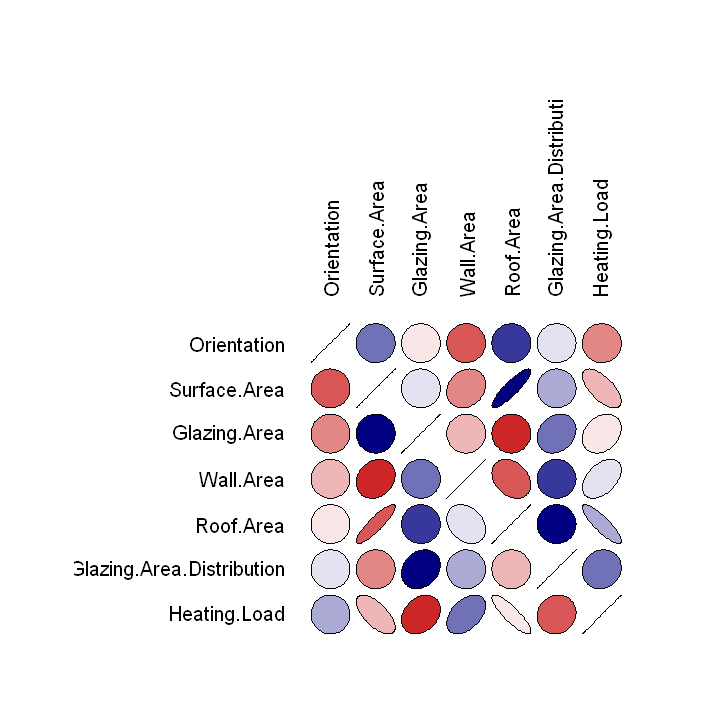

In [37]:
options(repr.plot.width=6, repr.plot.height=6)
library(ellipse)
R = cor(bldg.data[, c('Orientation', 'Surface.Area', 'Glazing.Area', 'Wall.Area', 'Roof.Area', 'Glazing.Area.Distribution',"Heating.Load")], method = 'pearson')
print(R)
plotcorr(R, col = colorRampPalette(c("firebrick3", "white", "navy"))(10))

It looks like Surface Area and Roof Area are the only two strongly correlated input varables to Heating Load, at least for linear fits.  Let's look at it in more detail:

Warning message in smoother(x, y, col = col[2], log.x = FALSE, log.y = FALSE, spread = spread, :
"could not fit negative part of the spread"

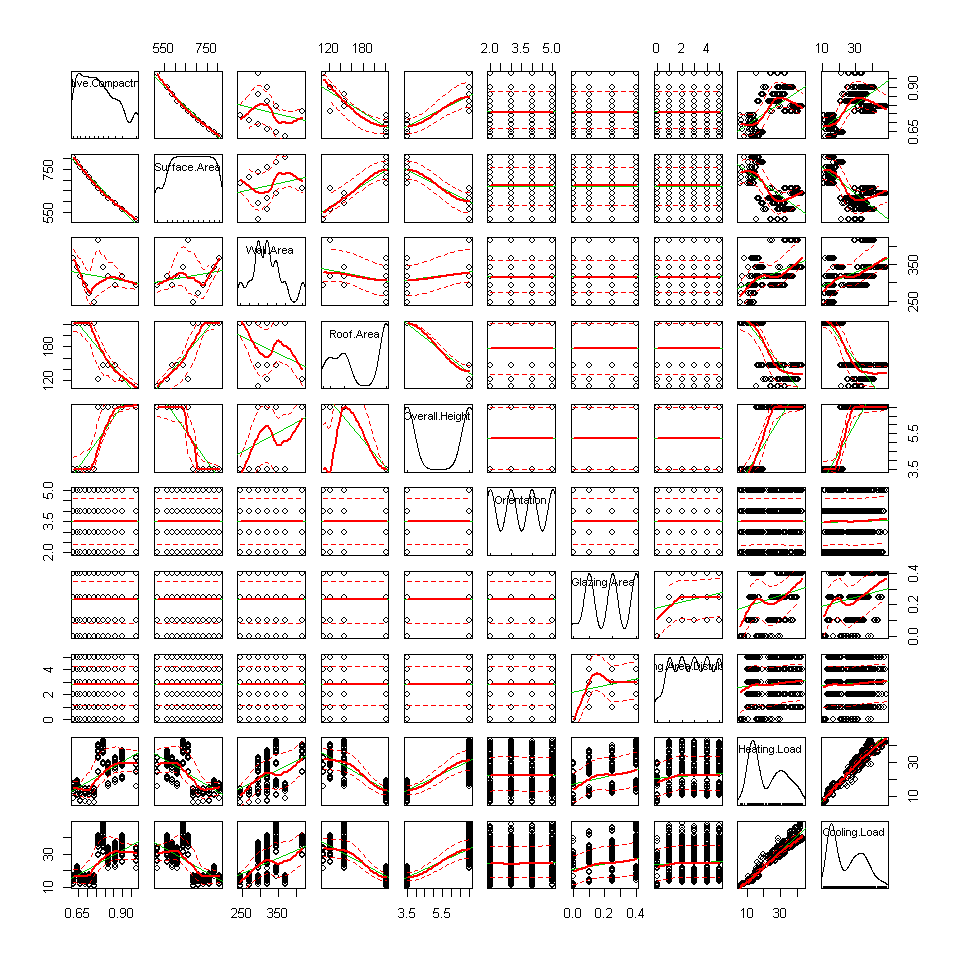

In [38]:
options(repr.plot.width=8, repr.plot.height=8)
scatterplotMatrix(~ Relative.Compactness + Surface.Area + Wall.Area + Roof.Area + 
Overall.Height + Orientation + Glazing.Area + Glazing.Area.Distribution + Heating.Load + Cooling.Load, data = bldg.data)

Now, normalize the continuous variables just in case:

In [39]:
# normalization function
norm <- function(x){
  return((x-min(x))/(max(x)-min(x)))
#  return (min(x))
}

SA.n <- norm(bldg.data$Surface.Area)
WA.n <- norm(bldg.data$Wall.Area)
RA.n <- norm(bldg.data$Roof.Area)
HL.n <- norm(bldg.data$Heating.Load)
CL.n <- norm(bldg.data$Cooling.Load)

#Or try lapply for normalization
bldg.data.n <- lapply(bldg.data,norm)
#Works OK but gives back a list.  I read up on plyr and tried ddply:
require (plyr)
bldg.data.n <-ddply(.data=bldg.data,.variables=bldg.data$colnames,.fun=norm)

Does this change the correlations?  No!

Warning message in smoother(x, y, col = col[2], log.x = FALSE, log.y = FALSE, spread = spread, :
"could not fit negative part of the spread"

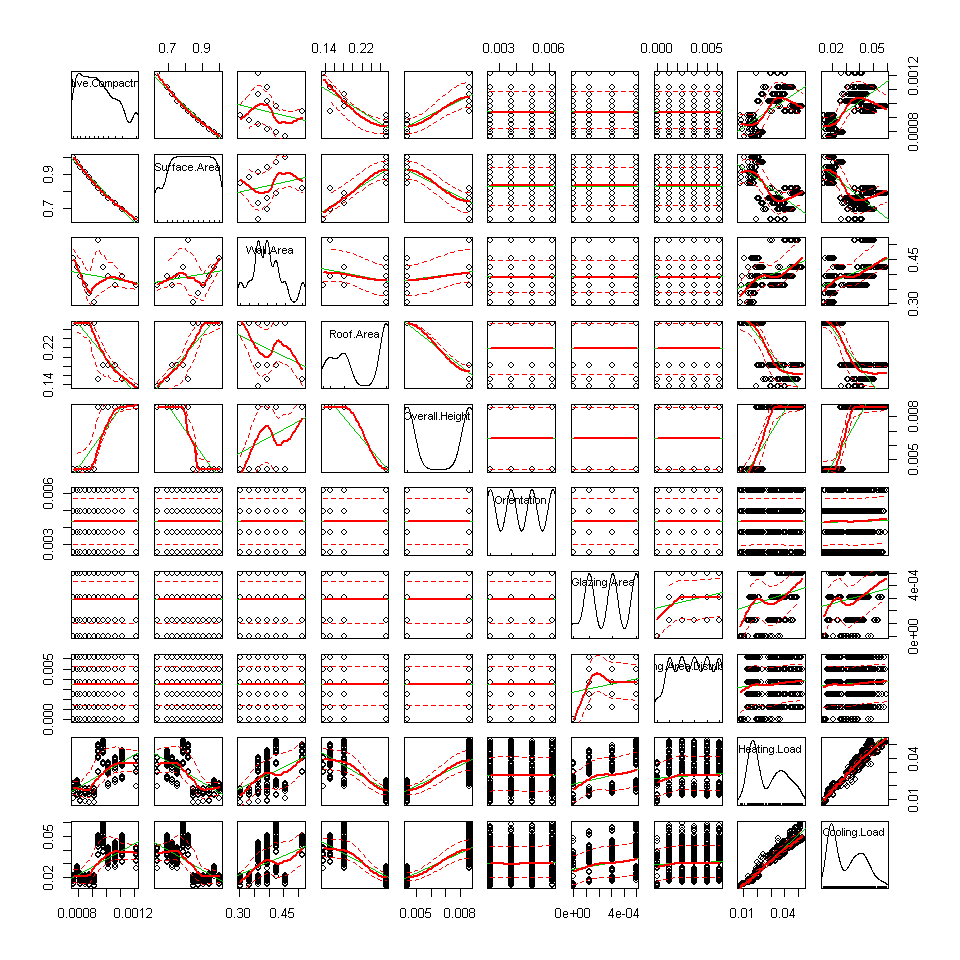

In [40]:
options(repr.plot.width=8, repr.plot.height=8)
scatterplotMatrix(~ Relative.Compactness + Surface.Area + Wall.Area + Roof.Area + 
Overall.Height + Orientation + Glazing.Area + Glazing.Area.Distribution + Heating.Load + Cooling.Load, data = bldg.data.n)

## Some Observations:
Heating and Cooling Loads are very similar and obviously bimodal.
Neither appear to depend strongly on Orientation or Glazing Area Distribution.
Maybe there is a weak linear dependence on Glazing Area
Notice that Overall Height and Roof Area are sort of inversely correlated to Wall Area.  Looks sort of cubic.

Let's explore that first.  We would expect some correlation between Height, Wall & Roof Areas, Surface Area, and Glazing Area.  If we plot Wall vs Roof Area with height as a factor something interesting happens:

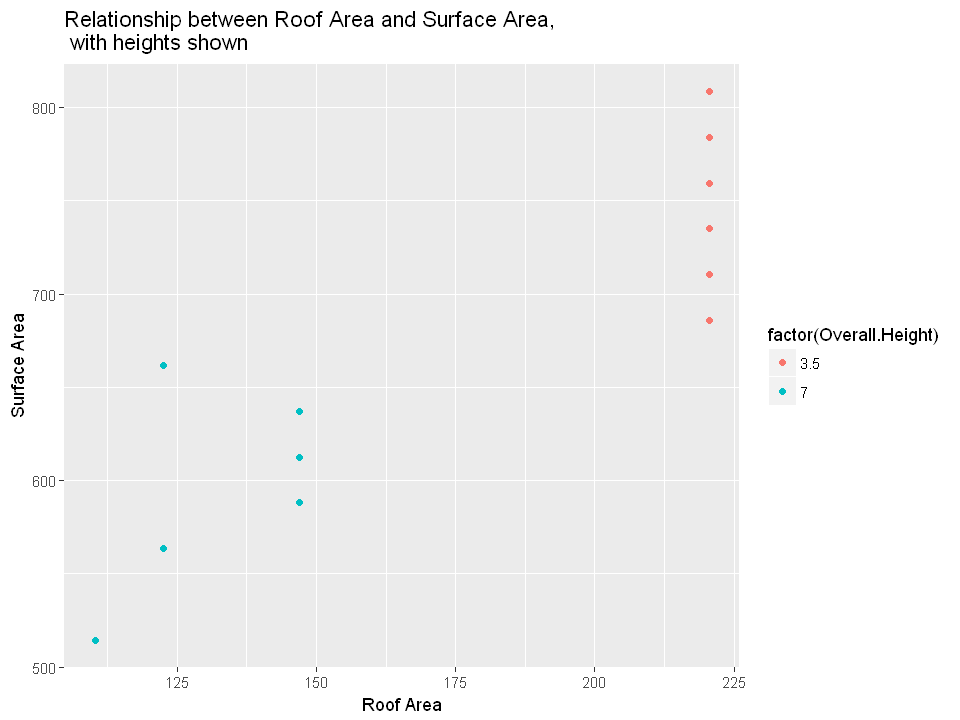

In [41]:
options(repr.plot.width=8, repr.plot.height=6)
ggplot(bldg.data, aes(Roof.Area, Surface.Area)) + geom_point(aes(color = factor(Overall.Height))) + 
  xlab('Roof Area') + ylab('Surface Area') + 
  ggtitle('Relationship between Roof Area and Surface Area, \n with heights shown')

Short buildings all have the same roof area.  Let's split the dataset into tall and short buildings:

In [42]:
Short<-subset(bldg.data,Overall.Height==3.5)
str(Short)
Tall<-subset(bldg.data,Overall.Height==7)
str(Tall)

'data.frame':	384 obs. of  10 variables:
 $ Relative.Compactness     : num  0.74 0.74 0.74 0.74 0.71 0.71 0.71 0.71 0.69 0.69 ...
 $ Surface.Area             : num  686 686 686 686 710 ...
 $ Wall.Area                : num  245 245 245 245 270 ...
 $ Roof.Area                : num  220 220 220 220 220 ...
 $ Overall.Height           : num  3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 3.5 ...
 $ Orientation              : num  2 3 4 5 2 3 4 5 2 3 ...
 $ Glazing.Area             : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Glazing.Area.Distribution: num  0 0 0 0 0 0 0 0 0 0 ...
 $ Heating.Load             : num  6.07 6.05 6.01 6.04 6.37 6.4 6.37 6.4 6.85 6.79 ...
 $ Cooling.Load             : num  10.9 11.2 10.9 11.2 11.3 ...
'data.frame':	384 obs. of  10 variables:
 $ Relative.Compactness     : num  0.98 0.98 0.98 0.98 0.9 0.9 0.9 0.9 0.86 0.86 ...
 $ Surface.Area             : num  514 514 514 514 564 ...
 $ Wall.Area                : num  294 294 294 294 318 ...
 $ Roof.Area                : num  110 110

So the data set is evenly split between tall and short buildings.  All short buildings have the same roof area. This implies some standard kind of building.  Since there is variation in heating load:

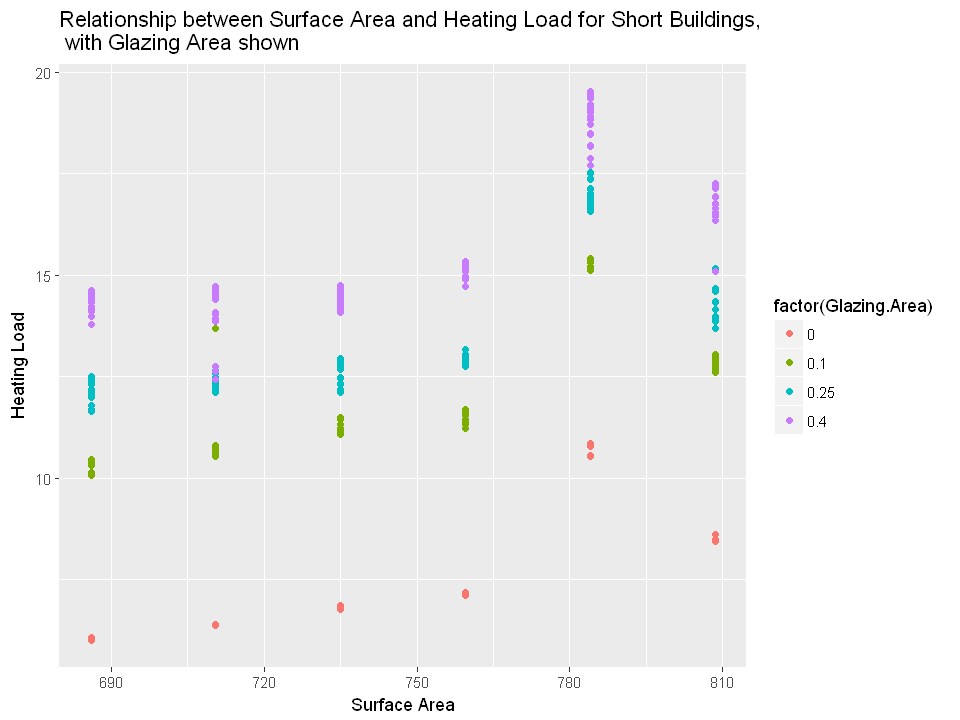

In [43]:
ggplot(Short, aes(Surface.Area, Heating.Load)) + geom_point(aes(color = factor(Glazing.Area))) + 
  xlab('Surface Area') + ylab('Heating Load') + 
  ggtitle('Relationship between Surface Area and Heating Load for Short Buildings, \n with Glazing Area shown')

So Heating Load seems to be positively correlated to Glazing Area more than Surface Area.  Given that windows are in general more thermally conductive than walls, this makes sense.  The cluster at around 780 must have something else going on.  Looking at just the buildings without windows (Glazing Area = 0), is there anything else obvious going on?

 Relative.Compactness  Surface.Area     Wall.Area       Roof.Area    
 Min.   :0.7600       Min.   :514.5   Min.   :294.0   Min.   :110.2  
 1st Qu.:0.7900       1st Qu.:563.5   1st Qu.:294.0   1st Qu.:122.5  
 Median :0.8400       Median :600.2   Median :318.5   Median :134.8  
 Mean   :0.8517       Mean   :596.2   Mean   :330.8   Mean   :132.7  
 3rd Qu.:0.9000       3rd Qu.:637.0   3rd Qu.:343.0   3rd Qu.:147.0  
 Max.   :0.9800       Max.   :661.5   Max.   :416.5   Max.   :147.0  
 Overall.Height  Orientation    Glazing.Area Glazing.Area.Distribution
 Min.   :7      Min.   :2.00   Min.   :0     Min.   :0                
 1st Qu.:7      1st Qu.:2.75   1st Qu.:0     1st Qu.:0                
 Median :7      Median :3.50   Median :0     Median :0                
 Mean   :7      Mean   :3.50   Mean   :0     Mean   :0                
 3rd Qu.:7      3rd Qu.:4.25   3rd Qu.:0     3rd Qu.:0                
 Max.   :7      Max.   :5.00   Max.   :0     Max.   :0                
  Heating.Loa

Warning message in smoother(x, y, col = col[2], log.x = FALSE, log.y = FALSE, spread = spread, :
"could not fit positive part of the spread"Warning message in smoother(x, y, col = col[2], log.x = FALSE, log.y = FALSE, spread = spread, :
"could not fit positive part of the spread"

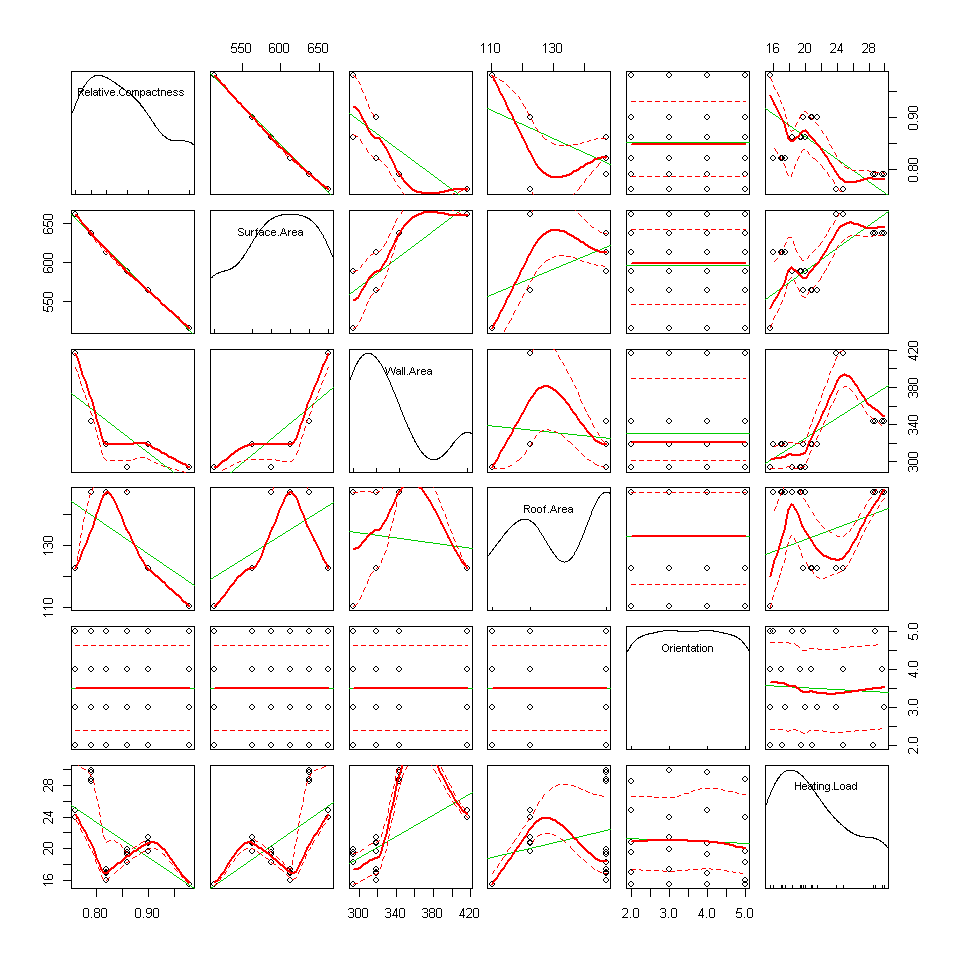

In [44]:
Tall.Dark<-subset(Tall,Glazing.Area==0)
summary(Tall.Dark)

options(repr.plot.width=8, repr.plot.height=8)
scatterplotMatrix(~ Relative.Compactness + Surface.Area + Wall.Area + Roof.Area + 
                    Orientation  +  Heating.Load, data = Tall.Dark)

Orientation does not seem be a big factor.  There are still interesting outliers in the Surface Area plots at around 625.  Roof Area seems to affect heating load less than wall area, but not in any clear way.

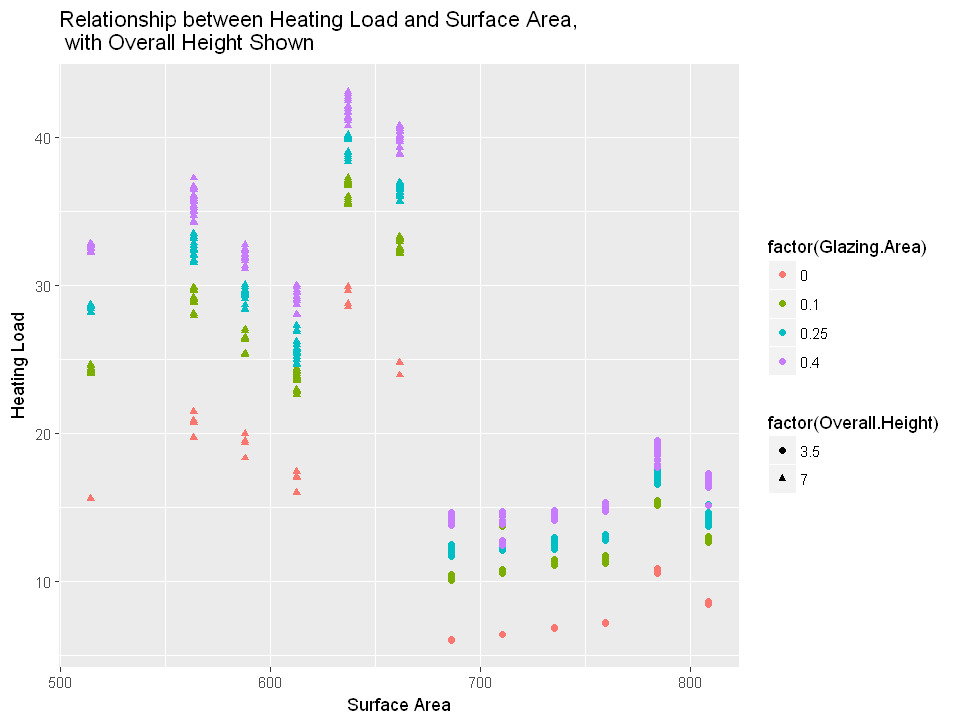

In [50]:
options(repr.plot.width=8, repr.plot.height=6)
ggplot(bldg.data, aes(Surface.Area, Heating.Load)) + geom_point(aes(color = factor(Glazing.Area),shape = factor(Overall.Height))) + 
       xlab('Surface Area') + ylab('Heating Load') + 
       ggtitle('Relationship between Heating Load and Surface Area, \n with Overall Height Shown')

(From Assignment 1): This graph summarizes the important discoveries so far:
1. Tall buildings have lower surface area than short buildings.
2. Heating Loads of tall buildings and short buildings are clustered in two distinct areas - short buildings generally run less than 15, and tall buildings are between 15 and 40.
3. Glazing Area appears to have the next strongest effect on Heating Load.  Larger Glazing Area generally implies higher Heating Load.

Additional observations for Assignment 2:
4. Even a small amount of glazing area appears to significantly increase the heating load.
5. The correlation with glazing area is consistent across all types of buildings and surface areas.
6. Orientation and Glazing Area Distribution don't seem to matter much.

Part 2:  I noticed that I made a mistake last week using Tall instead of Short buildings for the Dark (no glazing area) analysis.  Here is the corrected scatterplot:

 Relative.Compactness  Surface.Area     Wall.Area       Roof.Area    
 Min.   :0.6200       Min.   :686.0   Min.   :245.0   Min.   :220.5  
 1st Qu.:0.6400       1st Qu.:710.5   1st Qu.:269.5   1st Qu.:220.5  
 Median :0.6750       Median :747.2   Median :306.2   Median :220.5  
 Mean   :0.6767       Mean   :747.2   Mean   :306.2   Mean   :220.5  
 3rd Qu.:0.7100       3rd Qu.:784.0   3rd Qu.:343.0   3rd Qu.:220.5  
 Max.   :0.7400       Max.   :808.5   Max.   :367.5   Max.   :220.5  
 Overall.Height  Orientation    Glazing.Area Glazing.Area.Distribution
 Min.   :3.5    Min.   :2.00   Min.   :0     Min.   :0                
 1st Qu.:3.5    1st Qu.:2.75   1st Qu.:0     1st Qu.:0                
 Median :3.5    Median :3.50   Median :0     Median :0                
 Mean   :3.5    Mean   :3.50   Mean   :0     Mean   :0                
 3rd Qu.:3.5    3rd Qu.:4.25   3rd Qu.:0     3rd Qu.:0                
 Max.   :3.5    Max.   :5.00   Max.   :0     Max.   :0                
  Heating.Loa

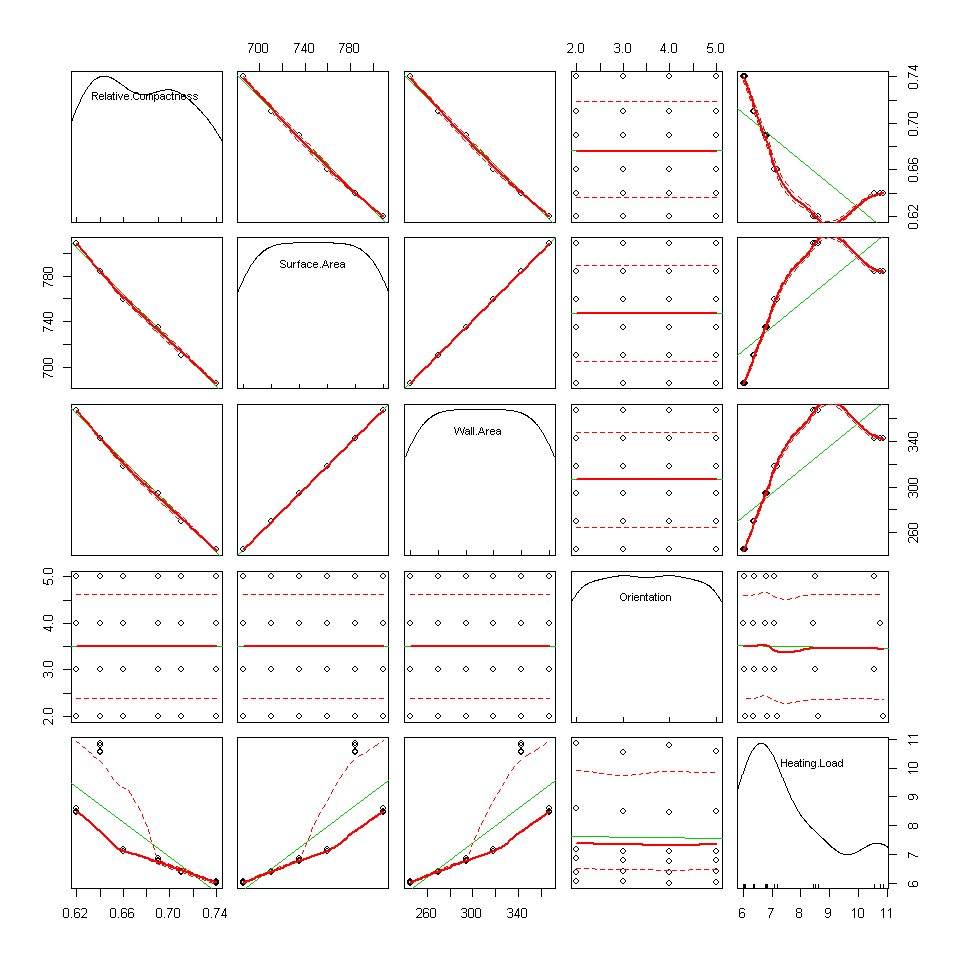

In [46]:
Short.Dark<-subset(Short,Glazing.Area==0)
summary(Short.Dark)
# note that Roof Areas are all the same, so 
options(repr.plot.width=8, repr.plot.height=8)
scatterplotMatrix(~ Relative.Compactness + Surface.Area + Wall.Area + 
                    Orientation  +  Heating.Load, data = Short.Dark)

Observations:
1. Orientation doesn't matter.
2. In this case, surface area and wall are are the same, so we can ignore one.  Also, relative compactness is pretty much the inverse of either, so it can be either ignored or used as a proxy for either.
3. The high heating loads at Wall Area = 340 are still unexplained by this cut of the data.  Since we are pretty much out of input variables at this point, this points to an unmeasured variable - perhaps these buildings have a different purpose or are in a different climate.
4. Since there are no windows and the roof area is the same, but the surface area is different, this sort of implies that the buildings must be different shapes and/or aspect ratios, if they indeed are all 3.5 height units tall.  For instance a square building will have total surface area of s^2+4(3.5) = s^2 +14s including the roof.  But a rectangular building with one side of 2s and the other of s/2, so the total surface area will be s^2 + 2(3.5)(2s) + 2(3.5(s/2)) = s^2 +17.5s, which is larger than the square case.
5. A model like this might explain the relationship between surface area and heating load for basic building shapes, with glazing being a more random factor on top of it.
6. The tall-dark subsets do not look so clearly correlated to Surface Area as the short-dark subsets.

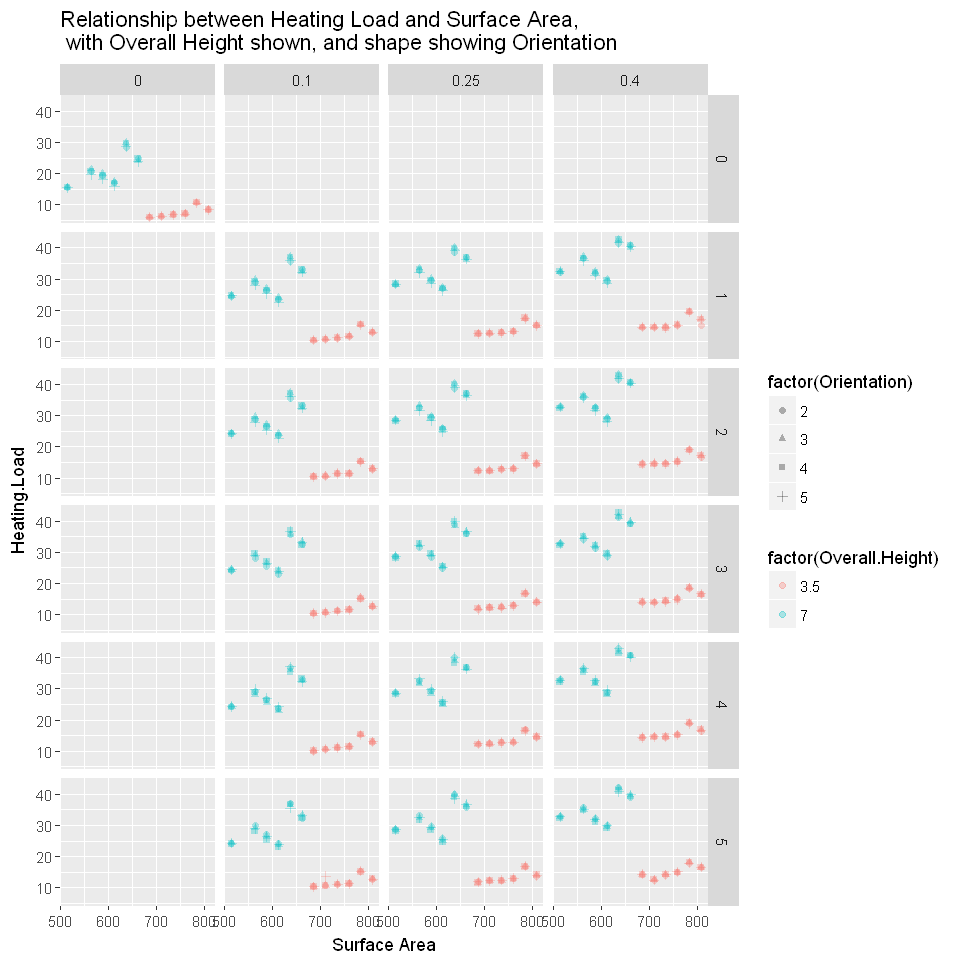

In [47]:

options(repr.plot.width=8, repr.plot.height=8)
ggplot(bldg.data, aes(Surface.Area, Heating.Load)) + geom_point(aes(color = factor(Overall.Height), 
    shape = factor(Orientation)), alpha = 0.3) + 
    facet_grid(Glazing.Area.Distribution ~ Glazing.Area) +
    xlab('Surface Area') + ylab('Heating.Load') + 
    ggtitle('Relationship between Heating Load and Surface Area, \n with Overall Height shown, and shape showing Orientation')

This plot seems to imply we have reached the end of the road.  Very little variation around the basic HL/SA groupings.  But let's look at one particular surface area - we can pick one at random as they all have the same number of data points.  Let's use SA = 808.5

 Relative.Compactness  Surface.Area     Wall.Area       Roof.Area    
 Min.   :0.62         Min.   :808.5   Min.   :367.5   Min.   :220.5  
 1st Qu.:0.62         1st Qu.:808.5   1st Qu.:367.5   1st Qu.:220.5  
 Median :0.62         Median :808.5   Median :367.5   Median :220.5  
 Mean   :0.62         Mean   :808.5   Mean   :367.5   Mean   :220.5  
 3rd Qu.:0.62         3rd Qu.:808.5   3rd Qu.:367.5   3rd Qu.:220.5  
 Max.   :0.62         Max.   :808.5   Max.   :367.5   Max.   :220.5  
 Overall.Height  Orientation    Glazing.Area    Glazing.Area.Distribution
 Min.   :3.5    Min.   :2.00   Min.   :0.0000   Min.   :0.000            
 1st Qu.:3.5    1st Qu.:2.75   1st Qu.:0.1000   1st Qu.:1.750            
 Median :3.5    Median :3.50   Median :0.2500   Median :3.000            
 Mean   :3.5    Mean   :3.50   Mean   :0.2344   Mean   :2.812            
 3rd Qu.:3.5    3rd Qu.:4.25   3rd Qu.:0.4000   3rd Qu.:4.000            
 Max.   :3.5    Max.   :5.00   Max.   :0.4000   Max.   :5.000     

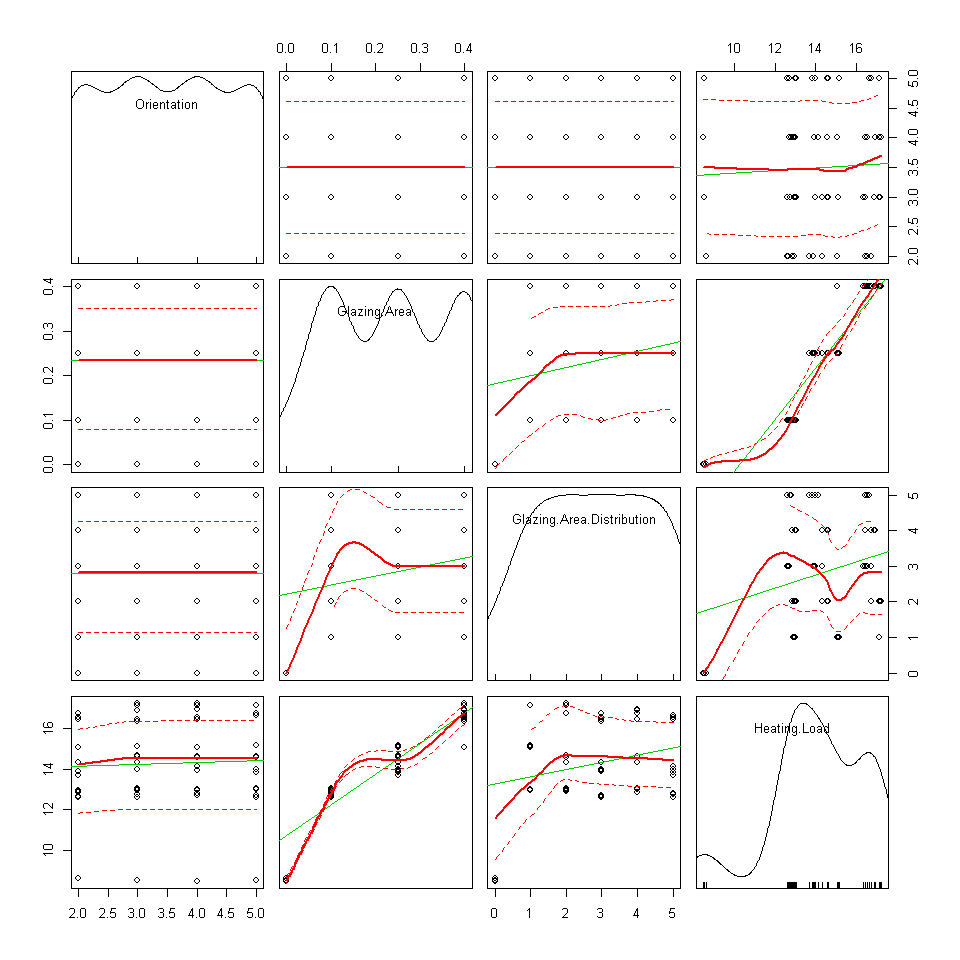

In [48]:
SAhigh <- subset(bldg.data,Surface.Area == 808.5)

summary(SAhigh)
# note that Roof Areas are all the same, so 
options(repr.plot.width=8, repr.plot.height=8)
scatterplotMatrix(~ Orientation  + Glazing.Area + Glazing.Area.Distribution +  Heating.Load, data = SAhigh)

Well, we can see that Heating Load is roughly proportional to Glazing Area -  but we already knew that.  It looks like it could be roughly 3rd-order.  Neither Orientation or Glazing Area Distribution has a larger effect.

Just for fun let's try a contour plot of Heating Load vs. Glazing Area and Glazing Area Distribution

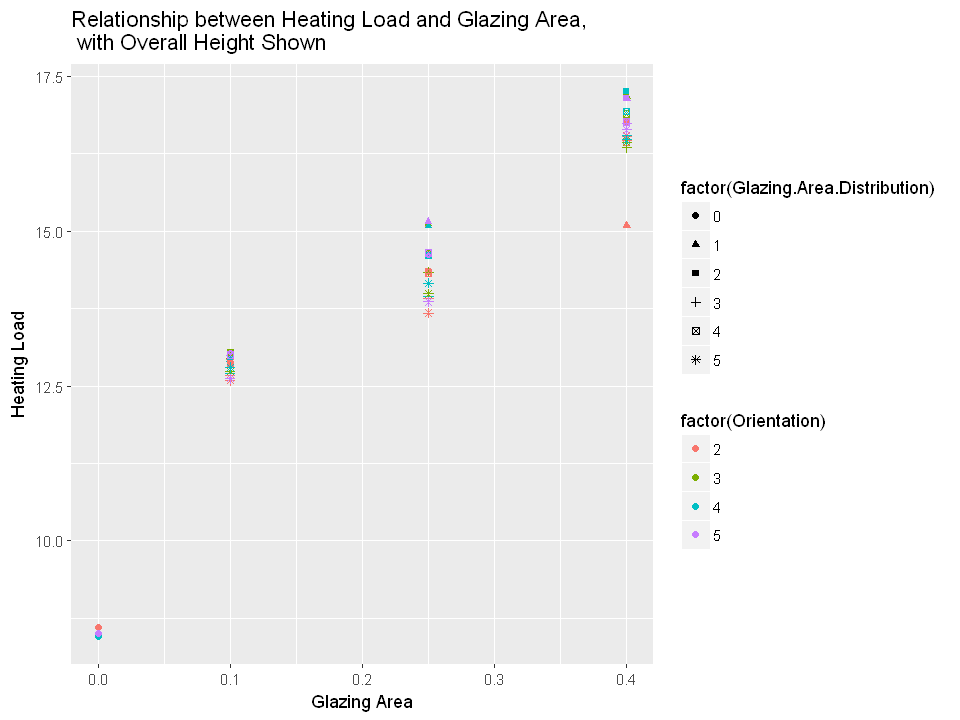

In [59]:
options(repr.plot.width=8, repr.plot.height=6)
ggplot(SAhigh, aes(Glazing.Area, Heating.Load)) + geom_point(aes(color = factor(Orientation),shape = factor(Glazing.Area.Distribution))) + 
       xlab('Glazing Area') + ylab('Heating Load') + 
       ggtitle('Relationship between Heating Load and Glazing Area, \n with Overall Height Shown')

What do we see if we look inside a particular Glazing Ara, say 0.25?

In [66]:
SAhigh.glaze <- subset(SAhigh,Glazing.Area == .25)

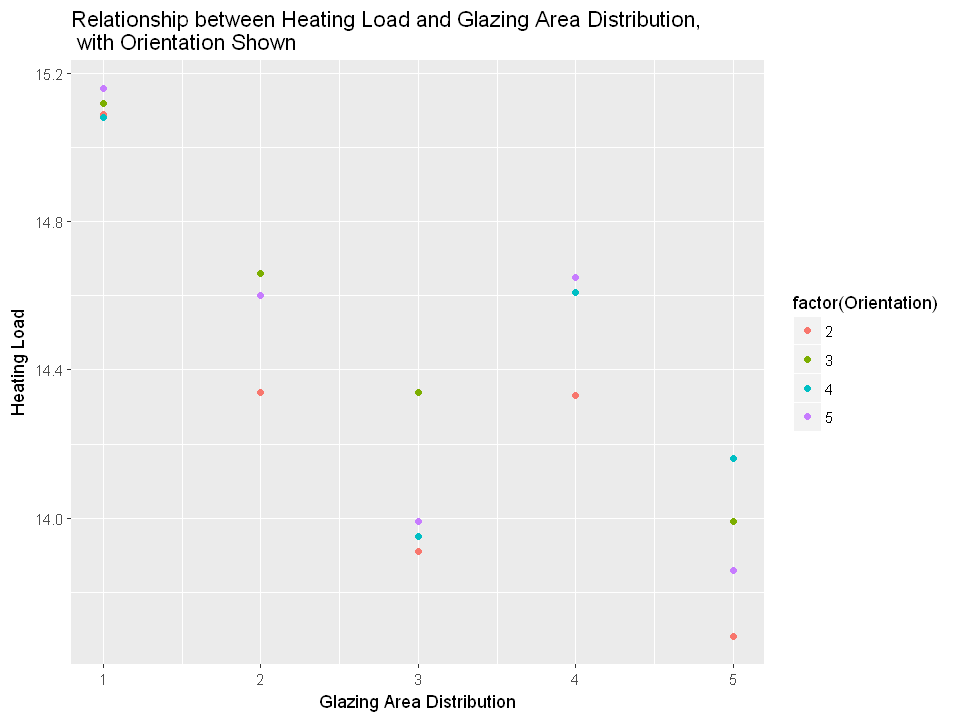

In [69]:
options(repr.plot.width=8, repr.plot.height=6)
ggplot(SAhigh.glaze, aes(Glazing.Area.Distribution, Heating.Load)) + geom_point(aes(color = factor(Orientation))) + 
       xlab('Glazing Area Distribution') + ylab('Heating Load') + 
       ggtitle('Relationship between Heating Load and Glazing Area Distribution, \n with Orientation Shown')

The range of Heating Load in this subset is now only 2, less than 5% of the total range, and it was the subset with the largest variation.  There is a general downward trend with increasing distribution, but no obvious structure otherwise.